In [41]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random

# Preparacion de los datos

importar matriz de datos con los resultados y dividir en entrada(x) y salida(y)

In [42]:
file_path = 'matriz_datos_resultados.xlsx'
# Load the Excel file into a DataFrame
df = pd.read_excel(file_path, sheet_name='Limpio')
# Assigning x and y variables
x = df[['y1', 'G_', 'wt_mea', 'z', 'T_gas', 'L_']]
y = df[['kGa (kmol/m³*hr*kPa)']]

In [43]:
# Initialize the MinMaxScaler
scaler_y = MinMaxScaler()
scaler = MinMaxScaler()

# Fit and transform the x variables
x_normalized = scaler.fit_transform(x)
y_normalized = scaler_y.fit_transform(y)

# Convert the normalized data back to a DataFrame
x_normalized_df = pd.DataFrame(x_normalized, columns=['y1', 'G_', 'wt_mea', 'z', 'T_gas', 'L_'])
y_normalized_df = pd.DataFrame(y_normalized, columns=['kG (mol/m²*s*kPa)'])


#Export normalization
joblib.dump(scaler, 'minmax_scaler_X.pkl')
joblib.dump(scaler_y, 'minmax_scaler_Y.pkl')

['minmax_scaler_Y.pkl']

Separando en train-test

In [44]:
X_train, X_test, y_train, y_test = train_test_split(x_normalized_df, y, test_size=0.2, random_state=42)

In [45]:
# Build the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split=0.2, verbose=0)

# Evaluate the model on the test data
test_loss, test_mae = model.evaluate(X_test, y_test)

print(f'Test Loss: {test_loss}')
print(f'Test MAE: {test_mae}')

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.2690e-07 - mae: 5.5739e-04
Test Loss: 4.2689694623732066e-07
Test MAE: 0.00055739312665537


In [51]:
def train_until_mae_below_threshold_enhanced(X_train, y_train, X_test, y_test, initial_config, threshold):
    # Initialize training parameters
    config = initial_config.copy()
    best_mae = float('inf')  # Track best MAE
    log_path = "training_log.txt"

    # Open the log file
    with open(log_path, "w") as log_file:
        log_file.write("Training Start Time: {}\n".format(datetime.datetime.now()))
        
        # Possible activation functions to cycle through
        activations = ['relu', 'sigmoid', 'relu']
        i = 0
        input_dim = X_train.shape[1]
        
        while True:
            # Create model with dynamic activations
            model = Sequential([
                Dense(config['neurons'][0], activation=activations[0], input_shape=(input_dim,)),
                Dense(config['neurons'][1], activation=activations[1]),
                Dense(1, activation='linear')
            ])
            model.compile(optimizer='adam', loss='mean_squared_error')

            # Fit model
            i += 1
            history = model.fit(X_train, y_train, epochs=100, batch_size=config['batch_size'], validation_split=config['val_split'], verbose=0)
            
            # Predict and evaluate
            y_pred = model.predict(X_test)
            mae = mean_absolute_error(y_test, y_pred)
            log_file.write("Config: {}, MAE: {}\n".format(config, mae))
            
            # If mae is > than 0.005 train it 5 times and see if it goes down
            if mae < 0.0005:
                r = 0
                while r < 5:
                    print('LESS than 0.00005, try number: ' + str(r))
                    history = model.fit(X_train, y_train, epochs=100, batch_size=config['batch_size'], validation_split=config['val_split'], verbose=0)
                    y_pred = model.predict(X_test)
                    mae = mean_absolute_error(y_test, y_pred)
                    print('MAE with the same configurations: ' + str(mae))
                    r += 1
                    if mae < best_mae:
                        best_mae = mae
                        best_model_path = "best_model.h5"
                        model.save(best_model_path)
                        print('NEW BEST MODEL SAVED with MAE: ' + str(mae))
                        log_file.write("New best model saved with MAE: {} at {}\n".format(best_mae, best_model_path))

            if mae < best_mae:
                best_mae = mae
                best_model_path = "best_model.h5"
                model.save(best_model_path)
                print('NEW BEST MODEL SAVED with MAE: ' + str(mae))
                log_file.write("New best model saved with MAE: {} at {}\n".format(best_mae, best_model_path))
            
            # Check if the MAE threshold is met
            if mae < threshold:
                print("Broke threshhold")
                break
            
            # Adjust parameters if needed
            # Cycle activations
            activations = activations[1:] + activations[:1]
            
            # Increase neurons
            config['neurons'] = [n + 2 for n in config['neurons']]
            
            # Adjust validation split
            config['val_split'] = random.uniform(0.2, 0.01)
            
            # Adjust batch size
            config['batch_size'] = random.randint(10, 33)

    return model, history

In [53]:
initial_config = {
    'neurons': [16, 8],  # Número inicial de neuronas en cada capa
    'batch_size': 10,     # Tamaño de lote inicial
    'val_split': 0.2      # Proporción de datos de validación inicial
}

In [54]:
model, history = train_until_mae_below_threshold_enhanced(X_train, y_train, X_test, y_test, initial_config, threshold=0.00002)

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


NEW BEST MODEL SAVED with MAE: 0.002753634399209917


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


NEW BEST MODEL SAVED with MAE: 0.0006749505232683435


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


NEW BEST MODEL SAVED with MAE: 0.0005711507479234105


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


MAE with the same configurations: 0.00012719572858470315
NEW BEST MODEL SAVED with MAE: 0.00012719572858470315
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
MAE with the same configurations: 0.0001904794286383178
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
MAE with the same configurations: 0.0005972297802398936
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
MAE with the same configurations: 0.0015519182897353804
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
MAE with the same configurations: 0.00034300463271725137


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
MAE with the same configurations: 0.000197427482039969
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


MAE with the same configurations: 0.00012679456563969828
NEW BEST MODEL SAVED with MAE: 0.00012679456563969828
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
MAE with the same configurations: 0.0002596745271437551
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0003210724957835985
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00017707006802097607


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00016521932401709566
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0001487169316768285
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00019482981228967068
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00039929944446196657
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.001340216546141676


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0006184026791886477
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.0032175393190451433
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.0004011699348992021
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.0019077680403341163
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00020068700008727262


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00016088122382273954
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00018308298391561694
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0001857851866554295
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MAE with the same configurations: 0.0001476995945484609
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0004966825014448693


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
MAE with the same configurations: 0.000787168459039556
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.006162438919041107
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
MAE with the same configurations: 0.0003278341110548592
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0004228027279460889
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
MAE with the same configurations: 0.00046224005702169975


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0004035091227984942
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
MAE with the same configurations: 0.0007314629003490729
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


MAE with the same configurations: 0.00011978322215319208
NEW BEST MODEL SAVED with MAE: 0.00011978322215319208
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
MAE with the same configurations: 0.0006488238259169074
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


MAE with the same configurations: 9.981729466778168e-05
NEW BEST MODEL SAVED with MAE: 9.981729466778168e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.00011888370417739949
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.00014428524160034047
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.001167196980173459
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0005478848539943415
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0010416773641817741


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


MAE with the same configurations: 8.631076536533444e-05
NEW BEST MODEL SAVED with MAE: 8.631076536533444e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 9.21813882180368e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


MAE with the same configurations: 8.608315608996964e-05
NEW BEST MODEL SAVED with MAE: 8.608315608996964e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 8.80568503101658e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00012858672978256574


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0023363394478687224
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0018251473372201176
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.0018141038633797842
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0008415471827829532
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0025425690726291915


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0005295944732820534
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0015471817092922123
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0002577236527674589
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MAE with the same configurations: 0.0004001498204154784
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.00019754761732745663


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0011601569390148182
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.002700898734826531
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00014605722828253095
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0024312175866087493
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.001954378411400303


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 8.969049733262883e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0064587247290733675
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.0007935914943840879
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0005060902772016566
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.000646983278205353


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0008854739103702354
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00021440434425389486
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.010823296436352922
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00011127374018168736
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00012593925337562133


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00012921116238145142
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00041773254094090896
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00013360620502958194
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.002781445901320286
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0001637597194094876


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.000417756280355996
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0012521198605743415
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00012991615119429777
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0008151055877980385
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
MAE with the same configurations: 0.00031139561019856134


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


MAE with the same configurations: 7.461613229153509e-05
NEW BEST MODEL SAVED with MAE: 7.461613229153509e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0001053967522742881
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
MAE with the same configurations: 0.0005177437262391398
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00018651914815716165
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0008714713088587999


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
MAE with the same configurations: 0.00016697894900764777
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
MAE with the same configurations: 0.00016923416010347089
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
MAE with the same configurations: 0.00026230315427977887
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
MAE with the same configurations: 0.00021384082523659997
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
MAE with the same configurations: 0.0004453330649888602


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
MAE with the same configurations: 0.006279098847769733
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
MAE with the same configurations: 0.0014997804488635481
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0005493351565195631
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
MAE with the same configurations: 0.0016373457093005993
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0001246753252333929


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
MAE with the same configurations: 8.22304548442544e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
MAE with the same configurations: 0.00011838381520868125
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
MAE with the same configurations: 0.0003099180076606673
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.027347884320409705
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
MAE with the same configurations: 0.0006280960632669066


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
MAE with the same configurations: 0.00019492833877799944
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00019867830193009763
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


MAE with the same configurations: 7.319120113425018e-05
NEW BEST MODEL SAVED with MAE: 7.319120113425018e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
MAE with the same configurations: 0.00013512001502818128
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
MAE with the same configurations: 0.0010737837448476515


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0006850609685088714
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0003630669703873999
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0004904513014222042
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 9.100999976042394e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00016482080737756068


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0002008236800705085
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.003961640017897057
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0032869006653329226
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0002335669232668362
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0007657426777042734


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


MAE with the same configurations: 5.139592015930212e-05
NEW BEST MODEL SAVED with MAE: 5.139592015930212e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.00012495350514897695
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00012143470547472232
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0008412837750459347
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.00016026822905911836


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 6.870479929949055e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00012496259640050713
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00014411308223357774
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


MAE with the same configurations: 4.2207666310094865e-05
NEW BEST MODEL SAVED with MAE: 4.2207666310094865e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0001645636629494166


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00036658784523544823
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00076074922164284
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00014223550654848715
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0016620449287956143
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0005768359005169147


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0001646649894351236
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
MAE with the same configurations: 0.00011291774269693792
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 6.646692529280595e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 7.64916066475458e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 6.58100691689069e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.004107800642966489
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.00025027399866779713
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.0001445746817550811
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.0001616166386633585
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 6.074473457652208e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 9.199924796343838e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.00013934265221579226
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.00024679542907917216
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0011019120046831235
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0005342534934275737


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00010977699142054119
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.006439527453308849
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 9.369629848684995e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.0005637083375470574
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 7.677102336021586e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00023400559563345097
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 9.082849120418135e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.000685848221950993
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.001515451323219175
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00031135864903974336


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.00022590207763912562
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0013604911441980618
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0005748858659913548
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0015954364258067265
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


MAE with the same configurations: 3.286517211374411e-05
NEW BEST MODEL SAVED with MAE: 3.286517211374411e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00029352758800435194
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.000165456465832281
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00011828773173588803
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0010387672632351285
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0009420647974756297


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00010225871930874231
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0001295311340120569
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0009156267409260775
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00031552117764671275
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.008343543561419737


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0006412866113002502
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0003537294319355993
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
MAE with the same configurations: 8.125518987730746e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00020737865718028304
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00014043262785146663


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.00018552361707578364
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 7.053114403945414e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00018385001832058737
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00040223126967716885
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0075832027907568435


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.0001843633344652986
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0008834999104583737
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 9.391239365195116e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00036178530048382515
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00010517278583418471


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.04992295357941995
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00046927927573991535
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0001134441221750212
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0027766450929765135
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.007723309678313457


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00013924770106371498
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 7.297656525211494e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.003904675280266138
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0001432144625236691
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00019205519823374447


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00014307204057382758
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 5.4554189372977145e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0002897940527296485
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00027849151564041157
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
MAE with the same configurations: 0.0009847307710371235


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0033596609545586886
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0019061113588544046
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00020207357861700968
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.001168791412681491
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0017025528603742193


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00013816924655577493
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00014629194465841117
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00018264543209703835
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 7.20003489832384e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0004103152695596226


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00010578309925209381
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00019856409254987201
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0025119901655531046
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0001367958297034226
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0003680554225793382


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00013656510852797028
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 6.0388013118363667e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0001674642089003956
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00027608698012253997
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00126322302009643


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 8.470432950928598e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00011131411641804622
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00012237967358813196
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 6.716250553859118e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00016432639864067924


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00010648651960407111
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 4.2270527835561514e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00011827558975527587
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.00011920019945030104
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00037302838378308606


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00011016691256075469
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 6.846922071991503e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 9.575159951439563e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00019074902020903026
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00920228581598348


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.003440654114674334
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00019810836170902472
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0005790966030274019
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.00011772001527619367
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.004219074051250675


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.0005728847761856665
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
MAE with the same configurations: 0.008156004682670748
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0041142373014289345
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
MAE with the same configurations: 0.00042122249741010547
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0020769118224385056


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.006252531813834926
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.00046801342178515214
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.004498995821970208
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
MAE with the same configurations: 5.9612613272099605e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0003457678331090676


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 5.112982883962004e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00012183881970674628
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0007057668457158983
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0006643957160195061
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0007446157797092889


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00011194735188174861
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 9.404427936897516e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0011824852526136004
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00038383124908280023
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.000827994208327075


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00020783324518560336
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.015156436051038539
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 6.975864371077822e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00015796446230315807
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 5.360394800553248e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00011080118912751935
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 6.938226504343442e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 4.157791143227466e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 6.706634737203028e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00012432841561947478


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00015616720131073617
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 8.428531099648673e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 6.986618921747526e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 6.951955909130848e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00039813904112568683


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 4.226751090336785e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


MAE with the same configurations: 3.1808540978988254e-05
NEW BEST MODEL SAVED with MAE: 3.1808540978988254e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.00042422790356066954
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 6.154499213101758e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0005294020326224015


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.00013720140376401055
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0005264908907982913
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.01301356908390173
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00045738945970098967
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00021232763201042463


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 9.009785804232938e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0002803886747040161
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0003061913975533575
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00019722925460842865
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0006292883778859726


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00022182468965222101
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 6.594003616998413e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 6.414838546818966e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 9.538007225892776e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.00011647423237396716


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
MAE with the same configurations: 9.485033115452908e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 6.0870790027564295e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00010031229968824109
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00010840456369895234
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0005645044138030172


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0016795827651251895
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 6.418086883580651e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 8.613296231712466e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0004891622687215873
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00027824976201238375


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
MAE with the same configurations: 0.0001083560083719047
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 5.260252227352386e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
MAE with the same configurations: 0.0001803955821190893
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0004276427192067512
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0027917087392966672


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 7.422515179969827e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.001451541896051303
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 7.239851591658949e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 3.215454336328869e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 5.6934368451892566e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00015523944500163894
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 5.78106286557605e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00041291166385156846
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00022542570274110423
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0008273388409901934


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0005082630660378581
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.001242219708788208
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 9.697432798596197e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0001996904878646746
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.002150039640393508


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00021052562166980839
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.003034989960004175
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0015576730150777308
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0020801725463627714
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.007050834176950689


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00020750298966509644
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0003580246625140457
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.005633110611183645
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.019502519516917748
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00011060373324613514


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0015622238369677223
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00022952483035651756
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0008793378316446066
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0009434977013037682
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.001623217635234019


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 6.841604102755398e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0010542847218884923
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.00010358328553646997
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00010743925545143794
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 8.08809369709738e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00014816918421483395
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0017647901502549127
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00026880584332777903
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.010250366006733585
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.003314033263650857


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00010941062529147375
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.00016724292000436285
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 5.313836732559084e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00021809368962095812
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0001419708609732082


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00010843369937156142
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0010058478790694791
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.000699742802494274
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0012814790392134893
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0018535938472321169


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 9.05780997842563e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00010738199288221706
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0003966324098988295
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00033821280050974525
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0001375888785513989


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0001166237591253138
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 9.845803570716647e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.000532628375048573
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.0051127576284727885
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0005432486628179994


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.012876901676534274
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0002401154277564343
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0056805386412538145
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 6.507548067719207e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00011236174236050909


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0017318761181378973
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0006620301165437068
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0021864664631108897
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.007475347836789809
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.005953092286750941


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 6.139952622007436e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.0003953835936377615
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.004498742783365054
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00684788842740921
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00211911803931421


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0011265580778261654
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0009799764534306836
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0037977166903564877
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 6.412209318638639e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 7.190816160998257e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00015519027729760213
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.027276060590409275
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.009229539676009146
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.000672437636512838
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0010560491175243107


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00014527604111452054
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0026088923397979587
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 4.9160460371126654e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 4.676791908391248e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 9.54566533029529e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0002764678882258153
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00014325846535814452
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00012249905107027107
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 4.893152271672546e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.000228112155316929


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 3.6345017135587544e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 9.332186527427412e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00014448722647921467
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00015883859605433877
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00014993293150746548


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00016189054362260864
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 6.112767696245328e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 7.20977759505366e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0006497606952876014
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0003666772688957205


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.0006096277567432959
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.000361080665713935
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.001775523552759418
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.009690019272245998
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00020073903687905966


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00018846866883388583
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00010062239244469373
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0002553259871814925
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0022806449692382353
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0024337925072936023


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 4.159788824185127e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 6.237627319058265e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 7.456674638556879e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 9.665092302857795e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 6.255006647205752e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00010058912768983726
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 7.688210580912073e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00010554835801517245
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 8.77539242934549e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 6.20015340464187e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 5.672494610361959e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 9.506504013311656e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0006270127217875701
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 8.424437450995881e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 7.672846524664704e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 7.08569853391825e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00023641918465744182
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
MAE with the same configurations: 0.00017627734560665735
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 9.678694571617234e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00016655394165080326


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 5.973631668791737e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0002722619657187023
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0033923825366603466
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0009772741211958754
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0006144856694268852


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.005877742105459287
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0014845881930783515
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0036427827006191753
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0004762921153799059
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.002728355453194783


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 6.54157346330732e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 6.567071416488615e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 8.281528244842003e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00011020269865130812
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00040270691486013395


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0007183728763018126
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0009055311931848002
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0027855343720594966
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00033871102274405935
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0020086188895147563


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00018953161733244154
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0001487937788993455
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00015475726594234014
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 8.57637540099712e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 5.700492602323924e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.000113121202519006
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0002987476330403983
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.010885509898598173
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0013568836196676968
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0013966615543519818


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 6.277333385106136e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 6.624821299704904e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 9.797027811883069e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 5.056194466171737e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0002243634468291746


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0004220894814846557
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00013748408803235202
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 6.478244740766002e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 4.4150402593653153e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 4.548459224364717e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0001060401845595634
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 9.221131276027542e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 4.868916805293115e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00017100929608303744
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00019798239022256618


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00017350746233753375
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0006577786160459351
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.004475383320102999
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0005299796538592908
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0006969382630552165


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00011482228750239154
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00010394229344958268
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.002050735003673089
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 5.353631844034466e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 9.654431893228513e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00020458132229124302
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 9.334628105504783e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0003857562502494872
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.001549862538869066
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.009389266813162449


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00018187234150104822
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.018988633280525753
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 4.0354951905814406e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 8.607719658292161e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
MAE with the same configurations: 0.0001688277118793392


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0003745104042254423
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.003984522078023523
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.02693445220179377
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.030964273606714925
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.007541759609732245


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00029682134893024197
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0014877209973669105
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0006035770120049185
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0018368221575209335
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00019392184215875221


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00010760979505202528
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0001494545555681311
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00022624377821671768
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.00027637699719902073
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.005274066960028506


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 5.903437109161496e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0003228554214136682
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 4.1953937653316125e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00010396353836154261
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 9.276906563098774e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0001042744389134452
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00046152313558664096
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0002922291379400449
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0005830704002822076
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.008615110207437406


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0028725657045182667
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00014368989269646554
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00010164807820354366
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
MAE with the same configurations: 0.0009679627677861069
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0006819706082262924


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.005691290418869853
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00011523690752437914
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00045324912009767076
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 8.246608950380405e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0001382360470234517


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0013585256328359253
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.00017296936681223906
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0035341119295034013
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0017525806381580504
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0014652117422696727


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00035735241201160817
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0001843935036471733
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0001849882224909903
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0006999283436983
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.002203105589945535


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0001181704287392454
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 6.542026555887206e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0008747361245883105
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00010544150871647946
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0004904676557986435


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 9.416693288139974e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00026651733044528753
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00027822839410616274
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00035010654423864746
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0017515823468451529


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 6.402510989792493e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00012286205058890227
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.001879673813624574
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0016449991300379896
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.002401129942043286


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.004350073944244422
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.002973156414743179
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.002977213505600445
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.000366884658826755
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0011725380922483401


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0006243612269120549
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0004123505292231307
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00012071370910672842
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0005573468065506652
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
MAE with the same configurations: 0.0023902856504033204


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.003826280659020128
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.010619723952453319
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 6.716526743437579e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00030202981211650777
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0001030181696717864


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00011745177580834053
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00012245598267795828
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0001483046084956392
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00014413391317586743
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00011443198912039376


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0032859918636963755
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00025210580942568883
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 4.4283182949337275e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0002830599994849687
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0004694579176273097


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 9.400002614727736e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0003408688969824988
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0033653919825083387
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.009749051787047516
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.023732369812094208


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 8.147104543018088e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 9.746861954176866e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 7.694962646310172e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0001620040452638258
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0012185738092029275


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00013263449823992145
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 6.259219283368812e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0003406967776848289
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0010136488258524674
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0006579222023439203


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00016753176265704744
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00015972881774584024
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0005846862198847049
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 8.59369568237881e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00011776684331085009


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00016575177485668693
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0013503244546955178
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.005720240516433226
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.000254981698915835
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0003027774866418374


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00010664464364547203
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 3.865100632766531e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00017818018300411512
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00010661107757345257
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00023168191524270855


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.0005575271540912827
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.006414061465703752
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.001374770312076302
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0008890218309603374
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00920748649442249


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0008852050599224325
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 5.0056793028349304e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 5.247247001665924e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00016247830234079728
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 4.5270035784789356e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00011819675604944559
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0005122068804869687
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0015500526307975337
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.004065719548402557
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00438112407229761


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 4.705574944413659e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00010297185893503173
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0002595433003085239
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.002043880403904672
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00397973233307281


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00013790067822946425
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00039900785312052116
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.004705390856223979
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0008941251428113975
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0014611445416116296


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 4.3821253901673394e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 5.390438995972192e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0001486126460424487
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00010691988137122754
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00019437893012311664


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.004245311690472597
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.006124309734662729
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0009419660623337017
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0025747407309796135
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
MAE with the same configurations: 0.003742773764256389


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 6.35830973274176e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 4.3100875281568664e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00020685811892954525
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0003099940238355694
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.01427016976367097


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00032228817762626705
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0074593009492600615
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.015236056230275227
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.003284461666675017
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.002521729983078583


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.005421505364411644
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0011058030021420045
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0005617520566784663
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.005765863514749599
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.006547568053384445


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 7.841208768447521e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 7.84061294810492e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0001082902208048084
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 6.555696968833911e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00011173731930388396


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 7.86168265260126e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 7.279534441265167e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 7.970044377384429e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 7.471459506067069e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0001024182360938163


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 6.332236748826191e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 9.594769321293807e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0001510155336363899
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 6.10179266077086e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00029079219375068157


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 8.373403804483221e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 7.597541589999186e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 8.321983918666279e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.019005445153008612
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0053106518926849325


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.001006977396893482
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0001130425362605153
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0003197964410844384
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0001031112754607774
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.000659025978394967


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00015901736158183518
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 9.239551144695598e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00014134424540962977
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00025811387780308795
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 7.375160464665141e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0013076590967159767
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0002784960706260071
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0026635981124408
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0013391994545787049
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0013851511896136874


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00014780986098623697
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00011234352488479262
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 4.7972883417854915e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
MAE with the same configurations: 0.003173758096305918
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0005804290612421472


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00033435496891336553
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00027506566871105486
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00025659783659057824
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


MAE with the same configurations: 3.048737787291636e-05
NEW BEST MODEL SAVED with MAE: 3.048737787291636e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.002062255905696403


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 7.597084154343093e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.017872860639278114
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.013313043982433954
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.01665266090660276
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.020409840671234365


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00010044803436112729
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00020759326035253936
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00010140644890380243
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00042499960139961697
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 8.838203048243138e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00018264164251401813
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 7.275248682764369e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0001287287391578355
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
MAE with the same configurations: 0.00021424109238120135
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0005564720307276132


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 6.19172951590836e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 4.3788707824540084e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 6.382017858924763e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MAE with the same configurations: 6.563473286480702e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0001713949430511394


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 8.541501259883423e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00011916549752314967
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0017049055284514831
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0005634026797461851
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0005008152759624332


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00011245664567664238
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0005074894633343389
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.04651319293427202
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00022706705021974686
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.009303054825647068


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 8.18852483814229e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00014434048116381579
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 5.902141116263379e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00019040685937422248
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 7.988843249277692e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 7.271049682842855e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00011211054898536789
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 5.897839797324733e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0002336357550562934
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.06066139237301104


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 8.14315271430697e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00011623180439596898
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00011935448007624277
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.000362332948989166
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0005358604604329562


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 8.233738427809239e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 7.863498094414748e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.00014021085206612581
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00010016611192895172
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0009575305206121087


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.001954826329387676
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 3.841305246333644e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
MAE with the same configurations: 0.004443281100774981
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00012858567658452028
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0004531678073305762


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 4.629394472967401e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 3.726692661887016e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 6.192237100895151e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 9.174259590358162e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 3.6569469588320955e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.00011146603400797744
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0003661700057616199
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.005979285066805946
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0013017522253181261
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.013349766563735372


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 5.063871018057538e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00014108777634747505
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00015646382999177352
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00010136638574883654
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.003588105453726955


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 4.4653657083698597e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 8.637773851801966e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 4.19167096586448e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 8.470474690618013e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0002282455165138432


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MAE with the same configurations: 4.631894471714667e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 5.596059711034506e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 4.748592025394406e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 3.822980962053742e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 5.451744890054161e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
MAE with the same configurations: 9.353850345925983e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00026332274001677195
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00015586985130980682
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00012471924610419016
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0010209690863713613


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 4.753968290307194e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
MAE with the same configurations: 5.665112714878098e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 3.407545102644347e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 3.602156780384846e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 6.702798774874453e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0005948185786556992
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0007535673904088184
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0010138431372996694
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.004734663734201076
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.013417369107427874


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 8.944946427495305e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 8.200251730862641e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 8.264125616105605e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0002209009104121487
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00046479485608141814


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0005952631604543761
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0016388238028102735
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0034936810628558895
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0013180859602008553
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.005329959802052006


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.002995446144600772
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0002512684546888602
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 4.4309906952407224e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 6.17647120640972e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 6.426952529081043e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00012240869787044048
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00041040689529265597
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.023681360476406028
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0009740036645931795
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0007164257845103085


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 7.384352913497873e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 4.4066088406799115e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0003736379194701843
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.003012551900302648
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 6.988493354295734e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.005557353216767044
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.002845465549169857
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 9.7977576211536e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0003631489553626607
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 9.730455505608335e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 6.640520659110502e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0003649909513821567
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0369586857234213
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.010744747626041195
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.02164141782570577


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00012852745066018582
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 7.409550555034096e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0008618131998471359
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 3.283379831156739e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 4.45307992770858e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 5.593257732980274e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00014007576833486402
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 5.349767582178223e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 6.851947068871602e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 7.087526482257725e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00017113898847513807
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0010816617842545962
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.03477093632610195
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0010146203533129999
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.002908676583431128


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 8.235696319922265e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0002150455827473908
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00012177106203724159
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0001420289762047898
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0019921812776216266


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0004565660624450879
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.020542283249182506
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0007945160981315579
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0004224588927099755
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.026455905042433843


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 5.742478141415378e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 5.4805509860540406e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00028355005215553345
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00034989140435875645
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0001750717892677793


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
MAE with the same configurations: 4.6140144670618986e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 4.662497599031867e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 6.976623464790252e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00010776509699674421
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 6.291113817115127e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0002982988831432589
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 9.419675215912623e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0003523182690457566
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.0003761764430419385
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.001055603591938803


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 7.72533916174157e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0003208215473506619
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.000647300152349186
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0004482668058366656
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 9.515033363458293e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 5.797736909319055e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00015888668005672289
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 7.771608658859319e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.00012190067269390002
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0010650558474712699


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0003986648347058971
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0014674206929368835
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0010915319442501563
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 4.991614281864842e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0001287231924091313


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 8.459114255415585e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 7.552955684151012e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0003106337257974907
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00011700157006863675
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00017838629507525394


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00024128659135413686
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0017492228320757084
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 7.680985787221898e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00019542848501676448
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 7.151008899201386e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00011966241416921797
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0002610560120883671
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.001840714701296495
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00029098860578734704
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0003546561112415003


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 5.624103326881109e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 5.9722791652874055e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 7.260541451075256e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.007290128235180596
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 5.093287391139926e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0009593624232873773
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 3.760205838265408e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00022181141777117538
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0008337279342871893
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0022523294012006647


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
MAE with the same configurations: 6.66160911756828e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 4.760136971142266e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0026046708690752947
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.001268553627277592
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.005308654638162149


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0009633131211398999
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0011102538705702193
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0002106095264697467
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0013998811087015197
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00019387525123449687


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00036930390622520097
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00012783186820681535
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00017923628156537666
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0036867764727430696
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.009700529057687415


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00018739782137682483
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.024657195919065473
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00023582011341801798
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00030647762087703445
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 8.813574321504166e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 4.585684347155623e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 3.767269598835298e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 5.7152236930695045e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 3.5344025550946435e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 7.327800551256282e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00024622016462415454
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0001618656785908257
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00025696963992023113
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.0004203008547140544
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0016984573173131365


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 4.178740603383312e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 6.80095161361669e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 8.094609335027598e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 5.6201364333925374e-05
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 6.754072189072575e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0003526117220723304
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00014513851414196135
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00019218733223740615
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.00017146532775810339
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00034347240923983635


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 4.522752872280786e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 4.892234264102355e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 5.015868442065184e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00012402839462552148
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00021155739075562238


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 7.117600885609748e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.000126362424122435
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00018608782484808066
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.015635018616005244
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0007888568693239141


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0002113704988121761
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 0.00012082385769855554
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.005584910266347695
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0006066102664373351
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00013873495487830493


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 9.806732566913417e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 8.727731691741379e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.0002082806534880233
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0001319351008475884
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 7.904657211706283e-05


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 8.883608409481334e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0001575610208791598
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 5.288184913159815e-05
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00022266456742173156
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE with the same configurations: 0.00011110408999885068


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00014801040276215177
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE with the same configurations: 5.8760443057907636e-05
LESS than 0.00005, try number: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE with the same configurations: 0.00010488603162307017
LESS than 0.00005, try number: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.0008528441480314837
LESS than 0.00005, try number: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE with the same configurations: 0.00025842421167888123


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LESS than 0.00005, try number: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


MAE with the same configurations: 2.4367305027108534e-05
NEW BEST MODEL SAVED with MAE: 2.4367305027108534e-05
LESS than 0.00005, try number: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
MAE with the same configurations: 3.2056682992127846e-05
LESS than 0.00005, try number: 2


KeyboardInterrupt: 

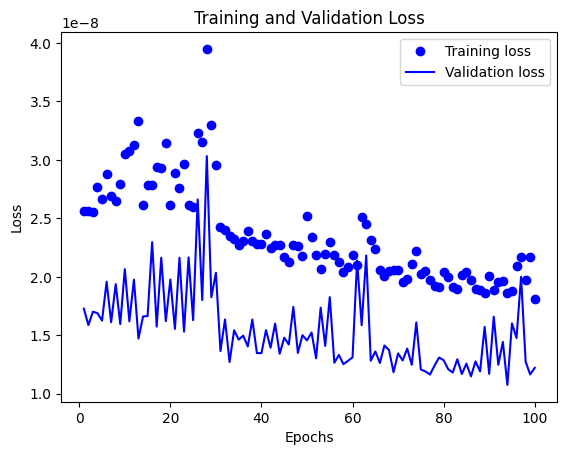

In [49]:
# Assuming history is returned by model.fit
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
# Plotting the training and validation loss
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')  # 'bo' gives us blue dot
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # 'b' gives us a solid blue line
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Print the metrics
print(f'R-squared (R2): {r2:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.6f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
R-squared (R2): 0.99
Mean Squared Error (MSE): 0.00
Mean Absolute Error (MAE): 0.000125
Root Mean Squared Error (RMSE): 0.00
